This notebook shows how the parallel vs orthogonal rule representations can arise in three artificial place cell populations in Figure 4

In [2]:
# import the packages
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from scipy.stats import norm, multivariate_normal
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

from scipy.spatial.transform import Rotation as R
from joblib import Parallel, dump, load, delayed

In [ ]:

unique_axislocs = np.array([-2,-1,1,2])
n_unique_axisloc = len(unique_axislocs)

stimlocs = list(itertools.product(unique_axislocs, unique_axislocs))
print(stimlocs)

# set up palette for plotting
# set up color for different axis locations
axisloc_palhex = dict(zip(
    unique_axislocs,
    ['#FFD300', '#005800', '#9E4F46', '#00FFC1'] 
))
colz = list(axisloc_palhex.values())

# set up color for the different populations
choose_color_from = sns.color_palette("colorblind",10).as_hex()

print(choose_color_from)
choose_color_from
psgroup_huedict = dict(zip(["top-right","orthogonal","top-left"],
                           #["#15B01A","#BF9000","#030764"],# GREEN, yellow, darkblue
                           [choose_color_from[5],choose_color_from[7],choose_color_from[8]]
                           )) 


[(-2, -2), (-2, -1), (-2, 1), (-2, 2), (-1, -2), (-1, -1), (-1, 1), (-1, 2), (1, -2), (1, -1), (1, 1), (1, 2), (2, -2), (2, -1), (2, 1), (2, 2)]


In [5]:
# Generate a vector of place fields with specific alignment to another vector of place fields
def generate_remapped_vector(c, unique_locs, frac, invert=False,random_state=None):
    """
    Generate a new vector place fields 'a' such that the alignment between 'a' and 'c' is controlled by ``frac`` and ``invert``.\n
    

    Parameters
    ----------
    c : np.ndarray
        Reference column vector.
    frac : float
        Proportion of place fields to remap (0 to 1).
    invert : bool
        If True, invert the direction of the alignment.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    np.ndarray
        Vector 'a' with alignment theta to 'c'.
    """

    assert frac >=0
    assert frac<=1

    a = np.copy(c)
    
    rng = np.random.default_rng(random_state)
    
    # invert if specified
    if invert:
        a = -a

    # select a subset to remap
    N_R= int(frac*len(c))
    R_indices = rng.choice(np.arange(len(c)), N_R, replace=False)

    # randomly choose new place field
    a[R_indices] = rng.choice(unique_locs, N_R, replace=True) + rng.normal(loc=0,scale=0.1,size=(N_R,))

    return a

# Example usage for the function
c = np.random.randn(100)
frac,ivt = 0.3,True
a = generate_remapped_vector(c, unique_axislocs,frac, invert=ivt)
actual_theta = np.dot(c, a) / (np.linalg.norm(c) * np.linalg.norm(a))
print(f"Remap Frac: {frac}, Inverted: {ivt}, CosSim: {actual_theta:.4f}")

Remap Frac: 0.3, Inverted: True, CosSim: -0.5226


[-2, -1, 1, 2]


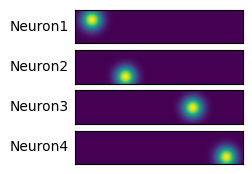

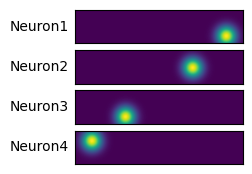

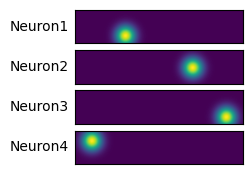

In [ ]:
# Part 1: example place fields for schematic illustration
print(unique_axislocs)
xx = np.arange(-.55, .45, 0.005) # width of the track
yy = np.arange(np.min(unique_axislocs)-.5, np.max(unique_axislocs)+.5, 0.01) # length of the track

rng = np.random.default_rng(123789)
fields_y = np.array(unique_axislocs) # preferred location on the linear track
fields_x = rng.random(n_unique_axisloc) * (xx.max() - xx.min()) + xx.min()+.001 # randomly sample preferred location along the width

# original map
fig, axes = plt.subplots(n_unique_axisloc,1,figsize=(6, 2))
for f,ax in enumerate(axes):
    tmp = np.outer(norm.pdf(xx, fields_x[f], .2), norm.pdf(yy, fields_y[f], .2))

    ax.imshow(tmp, extent=(yy.min(), yy.max(),xx.min(), xx.max()), origin='lower')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Neuron{f+1}",rotation=0,ha="right",va="center")

plt.show()


# inverted map
fig, axes = plt.subplots(n_unique_axisloc,1,figsize=(6, 2))
for f,ax in enumerate(axes):
    tmp = np.outer(norm.pdf(xx, fields_x[int(3-f)], .2), norm.pdf(yy, fields_y[int(3-f)], .2))

    ax.imshow(tmp, extent=(yy.min(), yy.max(),xx.min(), xx.max()), origin='lower')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Neuron{f+1}",rotation=0,ha="right",va="center")

plt.show()

# random remap
random_shuffle_loc = np.random.default_rng(139).permutation(list(range(n_unique_axisloc)))
fig, axes = plt.subplots(n_unique_axisloc,1,figsize=(6, 2))
for f,ax in enumerate(axes):
    tmp = np.outer(norm.pdf(xx, fields_x[random_shuffle_loc[f]], .2), norm.pdf(yy, fields_y[random_shuffle_loc[f]], .2))
    ax.imshow(tmp, extent=(yy.min(), yy.max(),xx.min(), xx.max()), origin='lower')
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(f"Neuron{f+1}",rotation=0,ha="right",va="center")
    
plt.show()



# Part 2: Simulation of population behaviour on two linear tracks

In [13]:

def generate_place_fields(N, unique_axislocs, theta, random_state=None):
    rng = np.random.default_rng(random_state)

    # generate random preference on one axis
    place_fields_x = rng.choice(unique_axislocs, size=N, replace=True)
    place_fields_x = place_fields_x + rng.normal(loc=0,scale=0.1,size=place_fields_x.shape) # add some noise

    # generate preference on another axis based on alignment(e.g no remap,anticorrelated,orthogonal)
    #place_fields_y = generate_cosine_similar_vector(place_fields_x, theta, random_state=random_state)
    place_fields_y = generate_remapped_vector(place_fields_x, unique_axislocs, 1-np.abs(theta), invert = theta<0, random_state=random_state)

    place_fields = np.vstack([place_fields_x, place_fields_y]).T
    
    return place_fields

def simulate_activity(unique_axislocs_x,unique_axislocs_y,place_fields,noise=0.1,rectify_ths=0,return_stimloc=False):
    N = place_fields.shape[0]
    activity = np.zeros((len(unique_axislocs_x),len(unique_axislocs_y), N))
    for idx_x,sx in enumerate(unique_axislocs_x):
        for idx_y,sy in enumerate(unique_axislocs_y):
            stimlocs[idx_x * n_unique_axisloc + idx_y] = [sx, sy]
            for n, xy in enumerate(place_fields):
                    activity[idx_x,idx_y, n] = multivariate_normal.pdf([sx, sy], mean=xy, cov=noise*np.eye(len(xy)))
    activity[activity < rectify_ths] = 0
    if return_stimloc:
        return activity, stimlocs
    else:
        return activity


N = 100 # number of cells in each population
n_sim =1
theta_lists = [-.8,0,0.8]
neural_PFs = dict(zip(theta_lists, [[] for _ in theta_lists]))
neural_activities = dict(zip(theta_lists, [[] for _ in theta_lists]))
neural_rdms = dict(zip(theta_lists, [[] for _ in theta_lists]))

with Parallel(n_jobs=10) as parallel:
    for j, theta in enumerate(theta_lists):
        neural_PFs[theta] = parallel(delayed(generate_place_fields)(N, unique_axislocs, theta, random_state=rs) for rs in range(n_sim))
        neural_activities[theta] = parallel(delayed(simulate_activity)(unique_axislocs,unique_axislocs,P,noise=0.1) for P in neural_PFs[theta])

        get_xy_rdm = lambda A: pairwise_distances(np.vstack([np.mean(A, axis=1), np.mean(A, axis=0)]), metric='correlation')
        
        neural_rdms[theta] = parallel(delayed(get_xy_rdm)(A) for A in neural_activities[theta])


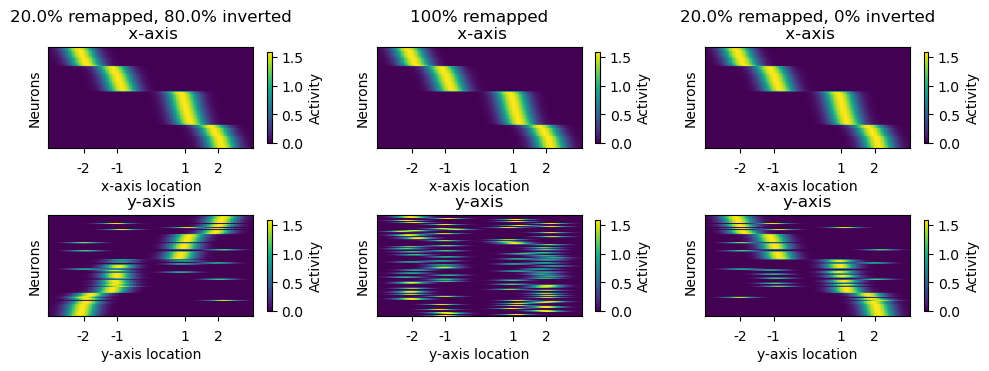

In [14]:
# plot the simulated behaviour
linprog = np.arange(-3, 3.1, 0.1)
zz = np.vstack([linprog,np.ones_like(linprog)*0]).T
rng = np.random.default_rng(123789)
pick_rs = rng.choice(range(n_sim),1,replace=False)[0]

fig_activity, axes_activity = plt.subplots(2,3,figsize=(12,4))

for j_pcol, theta in enumerate(theta_lists):
    ax_xtrack = axes_activity[0,j_pcol]
    ax_ytrack = axes_activity[1,j_pcol]

    # we sort neurons by the x-coordinate of their place fields 
    sort_byx_ = np.argsort(neural_PFs[theta][pick_rs][:, 0])

    # initialize place holder for storing activity
    Ax = np.zeros((len(linprog),N))
    Ay = np.zeros((len(linprog),N))

    fields_x = neural_PFs[theta][pick_rs][sort_byx_, 0]
    fields_y = neural_PFs[theta][pick_rs][sort_byx_, 1]


    for kcol,(fx,fy) in enumerate(zip(fields_x,fields_y)):
        Ax[:,kcol] =  multivariate_normal.pdf(zz, mean=[fx,0], cov=0.1*np.eye(2))
        Ay[:,kcol] =  multivariate_normal.pdf(zz, mean=[fy,0], cov=0.1*np.eye(2))


    imx = ax_xtrack.imshow(Ax.T)#, extent=(zz.min(), zz.max(), linprog.min(), linprog.max()),origin='lower')
    imy = ax_ytrack.imshow(Ay.T)
    cbx=fig.colorbar(imx,ax=ax_xtrack,shrink=0.65,fraction=0.2)
    cby=fig.colorbar(imy,ax=ax_ytrack,shrink=0.65,fraction=0.2)
    cbx.set_label('Activity')
    cby.set_label('Activity')

    

    if theta<0:
        ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, {100-np.round(1-np.abs(theta),2)*100}% inverted\n x-axis",fontsize=12)
    else:
        if theta==0:
            ax_xtrack.set_title(f"100% remapped\n x-axis",fontsize=12)
        else:
            ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, 0% inverted\n x-axis",fontsize=12)
    
    ax_ytrack.set_title(f"y-axis",fontsize=12)
    ax_xtrack.set_xlabel("x-axis location",labelpad=3)
    ax_ytrack.set_xlabel("y-axis location",labelpad=3)

for ax in axes_activity.flatten():
    ax.set_aspect(0.3)
    #ax.axis('off')
    
    xtickloc=[np.where(np.abs(linprog-x)==np.min(np.abs(linprog-x)))[0][0] for x in unique_axislocs]
    ax.set_xticks(xtickloc, labels=unique_axislocs)
    ax.tick_params(axis='x',pad=6)
    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    ax.set_yticks([])
    ax.set_ylabel("Neurons",labelpad=5)
    

fig.tight_layout()    
plt.show()



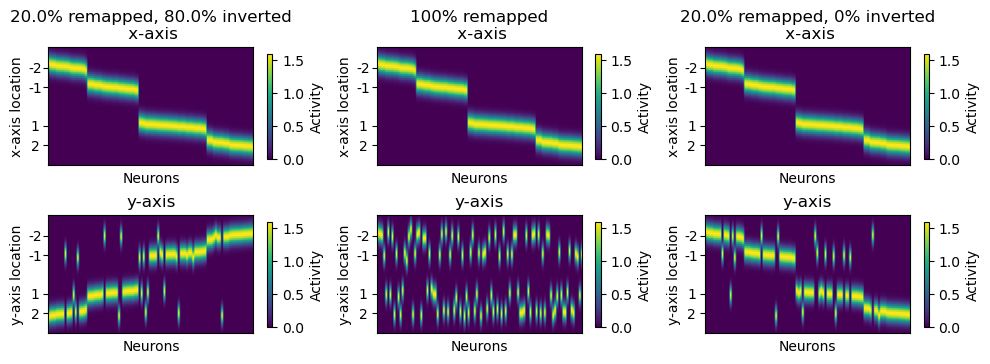

In [124]:
# Part 2: Heatmap of place fields on two linear tracks

linprog = np.arange(-3, 3.1, 0.1)
zz = np.vstack([linprog,np.ones_like(linprog)*0]).T
rng = np.random.default_rng(123789)
pick_rs = rng.choice(range(n_sim),1,replace=False)[0]

fig_activity, axes_activity = plt.subplots(2,3,figsize=(12,4))

for j_pcol, theta in enumerate(theta_lists):
    ax_xtrack = axes_activity[0,j_pcol]
    ax_ytrack = axes_activity[1,j_pcol]

    # we sort neurons by the x-coordinate of their place fields 
    sort_byx_ = np.argsort(neural_PFs[theta][pick_rs][:, 0])

    # initialize place holder for storing activity
    Ax = np.zeros((len(linprog),N))
    Ay = np.zeros((len(linprog),N))

    fields_x = neural_PFs[theta][pick_rs][sort_byx_, 0]
    fields_y = neural_PFs[theta][pick_rs][sort_byx_, 1]


    for kcol,(fx,fy) in enumerate(zip(fields_x,fields_y)):
        Ax[:,kcol] =  multivariate_normal.pdf(zz, mean=[fx,0], cov=0.1*np.eye(2))
        Ay[:,kcol] =  multivariate_normal.pdf(zz, mean=[fy,0], cov=0.1*np.eye(2))


    imx = ax_xtrack.imshow(Ax)#, extent=(zz.min(), zz.max(), linprog.min(), linprog.max()),origin='lower')
    imy = ax_ytrack.imshow(Ay)
    cbx=fig.colorbar(imx,ax=ax_xtrack,shrink=0.75,fraction=0.2)
    cby=fig.colorbar(imy,ax=ax_ytrack,shrink=0.75,fraction=0.2)
    cbx.set_label('Activity')
    cby.set_label('Activity')

    

    if theta<0:
        ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, {100-np.round(1-np.abs(theta),2)*100}% inverted\n x-axis",fontsize=12)
    else:
        if theta==0:
            ax_xtrack.set_title(f"100% remapped\n x-axis",fontsize=12)
        else:
            ax_xtrack.set_title(f"{np.round(1-np.abs(theta),2)*100}% remapped, 0% inverted\n x-axis",fontsize=12)
    
    ax_ytrack.set_title(f"y-axis",fontsize=12)
    ax_xtrack.set_ylabel("x-axis location",labelpad=3)
    ax_ytrack.set_ylabel("y-axis location",labelpad=3)

for ax in axes_activity.flatten():
    ax.set_aspect(0.94)
    #ax.axis('off')
    
    ytickloc=[np.where(np.abs(linprog-x)==np.min(np.abs(linprog-x)))[0][0] for x in unique_axislocs]
    ax.set_yticks(ytickloc, labels=unique_axislocs)
    ax.tick_params(axis='y',pad=6)
    plt.setp(ax.get_yticklabels(), rotation=0, ha='center')

    ax.set_xticks([])
    ax.set_xlabel("Neurons",labelpad=5)
    

fig.tight_layout()    
plt.show()



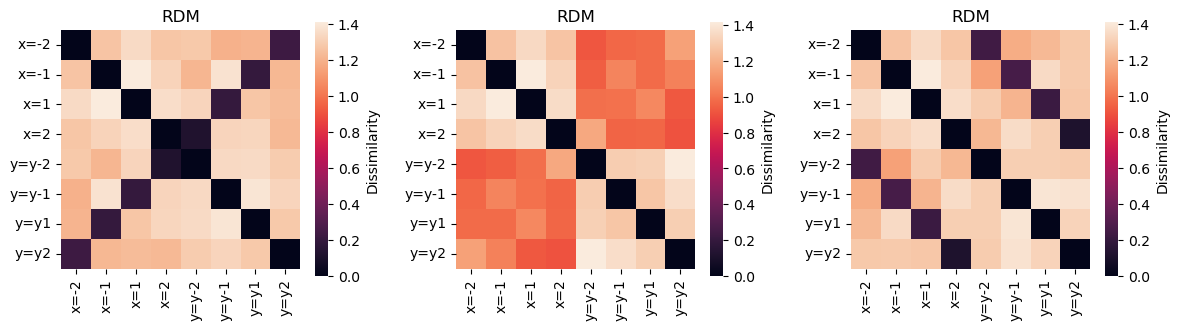

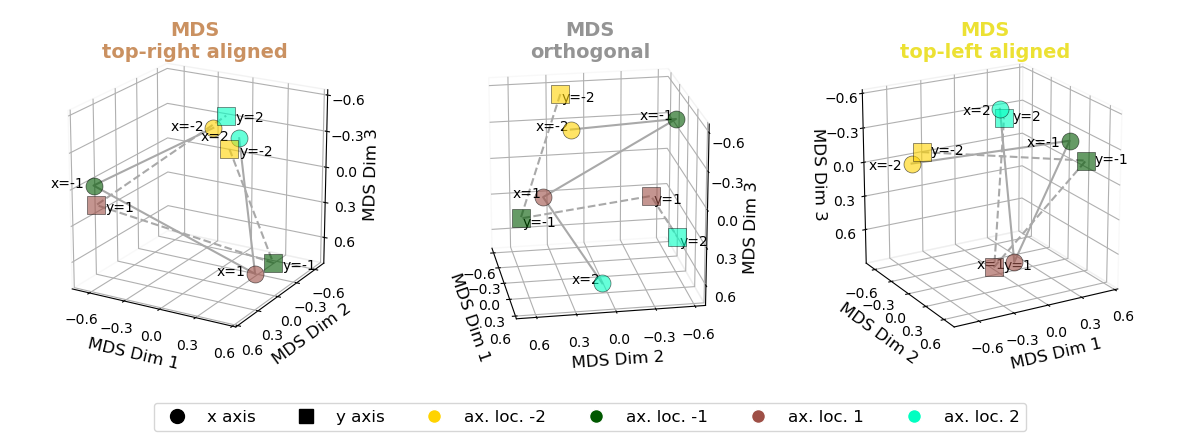

In [16]:
#

theta_viewpoints = dict(zip(theta_lists,
        [[-20,60,180],
         [-20,10,180],
         [-20,120,180]]))

mdstitles=dict(zip(theta_lists,
        ["MDS\ntop-right aligned",
         "MDS\northogonal",
         "MDS\ntop-left aligned"]))    
fig_rdm = plt.figure(figsize=(12,4))
fig_mds = plt.figure(figsize=(12,4))

for k, theta in enumerate(theta_lists):
    ax1 = fig_rdm.add_subplot(1,len(theta_lists),k+1)
    meanrdm = np.mean(neural_rdms[theta], axis=0)
    sns.heatmap(meanrdm, ax=ax1,square=True,
                cbar_kws={"shrink": .7,"label":"Dissimilarity"},
                xticklabels=[f"x={x}" for x in unique_axislocs]+[f"y=y{y}" for y in unique_axislocs],
                yticklabels=[f"x={x}" for x in unique_axislocs]+[f"y=y{y}" for y in unique_axislocs]
                )
    #ax1.set_title(f'fraction={np.round(1-np.abs(theta),2)*100}%, inverted={theta<0}\n RDM')
    ax1.set_title(f'RDM',fontsize=12)
    plt.setp(ax1.get_yticklabels(),rotation=0)
    plt.setp(ax1.get_xticklabels(),rotation=90)
       

    ax2 = fig_mds.add_subplot(1,len(theta_lists),k+1, projection='3d')
    mds = MDS(n_components=3, dissimilarity='precomputed',normalized_stress='auto',random_state=1).fit_transform(meanrdm)
    mds_df = pd.DataFrame(mds,columns=["MDS1","MDS2","MDS3"])
    mds_df["training_axes"] = ["x"]* n_unique_axisloc+["y"]* n_unique_axisloc 
    mds_df["axloc"] = unique_axislocs * 2

    for (ta, tl), group in mds_df.groupby(['training_axes', 'axloc']):
        ax2.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
                color=axisloc_palhex[tl], marker={"x":"o","y":"s"}[ta],
                s=150,edgecolor='black',linewidth=0.5,
                label=f'{ta},{tl}',alpha=0.6,zorder=2)
        if ta == "y":
            ax2.text(group['MDS1'].values[0]+0.08, group['MDS2'].values[0], group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="left",va="center",zorder=3)
        else:
            ax2.text(group['MDS1'].values[0]-0.08, group['MDS2'].values[0], group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="right",va="center",zorder=3)
        
    ax2.plot3D(mds[:n_unique_axisloc, 0], mds[:n_unique_axisloc, 1], mds[:n_unique_axisloc, 2],'-', color='darkgrey')
    ax2.plot3D(mds[n_unique_axisloc:, 0], mds[n_unique_axisloc:, 1], mds[n_unique_axisloc:, 2], '--', color='darkgrey')

    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False
    alignment = mdstitles[theta].replace("MDS\n","").replace(" aligned","")
    ax2.set_title(mdstitles[theta],y=.92,fontsize=14,color=psgroup_huedict[alignment],fontweight="bold")
    ax2.set_xlabel('MDS Dim 1',fontdict={"size":12},labelpad=5)
    ax2.set_ylabel('MDS Dim 2',fontdict={"size":12},labelpad=5)
    ax2.set_zlabel('MDS Dim 3',fontdict={"size":12},labelpad=5)

    ticks = [-.6,-0.3,0,0.3,.6]
    ax2.set_xticks(ticks)
    ax2.set_yticks(ticks)
    ax2.set_zticks(ticks)
    ax2.set_box_aspect([1,1,1],zoom=.85)

    ax2.view_init(*theta_viewpoints[theta])

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=axisloc_palhex[i], markersize=10, label='ax. loc. %d'%(i))
                for i in np.sort(mds_df["axloc"].unique())]
marker_legend = [plt.Line2D([0], [0], marker={"x":"o","y":"s"}[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                for i in np.sort(mds_df["training_axes"].unique())]
fig_mds.legend(handles=marker_legend + color_legend, loc='upper center', 
           bbox_to_anchor=(0.5, 0.),fontsize=12,
           ncol=6)

fig_rdm.tight_layout()
fig_mds.tight_layout()

plt.show()